# Predicting Medical Appointment No-Shows
Data from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments/home)

In [2]:
# Imports
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Helper functions
def unique_col_values(df):
    max_name_len = np.max([len(col_name) for col_name in raw_data.columns]) + 2
    format_str = "{:<" + str(max_name_len) + "}{:<8}{:<15}"

    print(format_str.format("Name", "Unique", "DType"))
    print()
    for col in df:
        print(format_str.format(df[col].name, len(df[col].unique()), str(df[col].dtype)))

def convert_to_category(df, cols):
    for col in cols:
        df[col] = df[col].astype("category")

## Preprocessing

In [4]:
# Import the data
raw_data = pd.read_csv("KaggleV2-May-2016.csv")
print("Rows: {}\nColumns: {}".format(raw_data.shape[0], raw_data.shape[1]))

# Clean up column names
raw_data.columns = ["patient_id", "appointment_id", "gender", "scheduled_day",
                   "appointment_day", "age", "neighborhood", "scholarship",
                    "hypertension", "diabetes", "alcoholism", "handicap", "sms_received",
                   "no_show"]
raw_data.head()

Rows: 110527
Columns: 14


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
# Get data details
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighborhood       110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
# Check for missing values
raw_data.isnull().sum()

patient_id         0
appointment_id     0
gender             0
scheduled_day      0
appointment_day    0
age                0
neighborhood       0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

In [7]:
# Check for duplicates using the appointment unique identifier column
raw_data.duplicated("appointment_id").sum()

0

In [8]:
# Drop unneeded columns
raw_data.drop(["patient_id", "appointment_id"], axis=1, inplace=True)

# Convert scheduled_day and appointment_day to datetime format
raw_data["scheduled_day"] = pd.to_datetime(raw_data["scheduled_day"])
raw_data["appointment_day"] = pd.to_datetime(raw_data["appointment_day"])

# Convert qualitative columns to category type
convert_to_category(raw_data, ["gender", "neighborhood", "scholarship", "hypertension",
                              "diabetes", "alcoholism", "handicap", "sms_received", "no_show"])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
gender             110527 non-null category
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighborhood       110527 non-null category
scholarship        110527 non-null category
hypertension       110527 non-null category
diabetes           110527 non-null category
alcoholism         110527 non-null category
handicap           110527 non-null category
sms_received       110527 non-null category
no_show            110527 non-null category
dtypes: category(9), datetime64[ns](2), int64(1)
memory usage: 3.5 MB


In [9]:
unique_col_values(raw_data)

Name             Unique  DType          

gender           2       category       
scheduled_day    103549  datetime64[ns] 
appointment_day  27      datetime64[ns] 
age              104     int64          
neighborhood     81      category       
scholarship      2       category       
hypertension     2       category       
diabetes         2       category       
alcoholism       2       category       
handicap         5       category       
sms_received     2       category       
no_show          2       category       


In [10]:
# Calculate time between appointment and appointment scheduling 
def calc_time_between(cols):
    appointment_day = cols[0]
    scheduled_day = cols[1]
    return (appointment_day.date() - scheduled_day.date()).days

raw_data["scheduled_to_appointment"] = raw_data[["appointment_day", "scheduled_day"]].apply(calc_time_between, axis=1)

# Drop observations with scheduled_to_appointment < 0
raw_data = raw_data[raw_data["scheduled_to_appointment"] >= 0]

# Create weekday feature
def get_weekday(date):
    weekday_codes = {0: "monday", 1: "tuesday",
                    2: "wednesday", 3: "thursday",
                    4: "friday", 5: "saturday",
                    6: "sunday"}
    return weekday_codes[date.weekday()]

raw_data["appointment_weekday"] = raw_data["appointment_day"].apply(lambda x: get_weekday(x)).astype("category")

# Remove nonsensical/unlikely  age observations
raw_data = raw_data[(raw_data["age"] >= 0) & (raw_data["age"] != 115)]

# Create age group feature
def age_groups(age):
    if age < 18:
        return "child"
    elif (age >= 18) & (age < 65):
        return "adult"
    else:
        return "senior"

raw_data["age_group"] = raw_data["age"].apply(lambda x: age_groups(x)).astype("category")

# Create neighborhood aggregates feature
neighborhood_count = pd.DataFrame(raw_data.groupby("neighborhood").count()["no_show"])
neighborhood_count.columns = ["appointment_count"]
neighborhood_group_names = ["very low volume", "low volume", "moderate volume", "high volume", "very high volume"]
neighborhood_count["neighborhood_volumes"] = pd.qcut(neighborhood_count["appointment_count"],
                                                     5, neighborhood_group_names)
neighborhood_count.loc["JARDIM CAMBURI", "neighborhood_volumes"]
raw_data["neighborhood_volumes"] = raw_data["neighborhood"].apply(lambda x: neighborhood_count.loc[x, "neighborhood_volumes"]).astype("category")

# Transform handicap to a binary 1 (yes), 0 (no)
raw_data["handicap"] = raw_data["handicap"].apply(lambda x: 0 if x == 0 else 1).astype("category")

# Create same-day-appointment feature: 1 if appointment occurred on the same day it was scheduled, 0 otherwise
raw_data["same_day_appointment"] = raw_data["scheduled_to_appointment"].apply(lambda x: 1 if x == 0 else 0).astype("category")


In [11]:
# Split into feature dataframe and target dataframe
features = raw_data[["gender", "age_group", "scholarship", "hypertension", "diabetes", "alcoholism",
                     "handicap", "sms_received", "neighborhood_volumes", "appointment_weekday",
                    "scheduled_to_appointment", "same_day_appointment"]]
target = raw_data["no_show"]

# Create dummy variables
features = pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110516 entries, 0 to 110526
Data columns (total 20 columns):
scheduled_to_appointment                 110516 non-null int64
gender_M                                 110516 non-null uint8
age_group_child                          110516 non-null uint8
age_group_senior                         110516 non-null uint8
scholarship_1                            110516 non-null uint8
hypertension_1                           110516 non-null uint8
diabetes_1                               110516 non-null uint8
alcoholism_1                             110516 non-null uint8
handicap_1                               110516 non-null uint8
sms_received_1                           110516 non-null uint8
neighborhood_volumes_low volume          110516 non-null uint8
neighborhood_volumes_moderate volume     110516 non-null uint8
neighborhood_volumes_very high volume    110516 non-null uint8
neighborhood_volumes_very low volume     110516 non-null uint8
appoint

In [13]:
X = features.values
y = np.array(target.values)

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(le.classes_)
print(le.transform(["No", "Yes"]))

['No' 'Yes']
[0 1]


In [14]:
y_pred = np.zeros(y.shape[0])
np.mean(y_pred == y)

0.79811972926997

### Up-sample

In [15]:
# Up-sample to balance target class
X_upsampled, y_upsampled = resample(X_train[y_train == 1], y_train[y_train == 1], replace=True,
                                   n_samples=X_train[y_train == 0].shape[0])

X_train_up = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_up = np.hstack((y_train[y_train == 0], y_upsampled))

In [16]:
y_pred = np.zeros(y_train_up.shape[0])
np.mean(y_pred == y_train_up)

0.5

### Down-sample

In [17]:
# Down-sample to balance target class
X_downsampled, y_downsampled = resample(X_train[y_train == 0], y_train[y_train == 0], replace=True,
                                   n_samples=X_train[y_train == 1].shape[0])

X_train_down = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_down = np.hstack((y_train[y_train == 1], y_downsampled))

In [18]:
y_pred = np.zeros(y_train_down.shape[0])
np.mean(y_pred == y_train_down)

0.5

### SMOTE

In [19]:
# SMOTE
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [20]:
y_pred = np.zeros(y_train_smote.shape[0])
np.mean(y_pred == y_train_smote)

0.5

## Training

In [21]:
# Set up results dictionary
results = {"model": [], "sample_method":[], "mean_train_acc": [], "std_train_acc": [],
           "test_acc": [], "tp": [], "tn": [], "fp": [], "fn": [], "recall": [],
           "precision": [], "f1_score": [], "runtime": []}

# Set-up helper functions
def print_confumat(confumat):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confumat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confumat.shape[0]):
        for j in range(confumat.shape[1]):
            ax.text(x=j, y=i, s=confumat[i, j], va="center", ha="center")
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.grid(None)
    plt.show()

def print_results(model, sample_method, mean_train_acc, std_train_acc, test_acc, rec_score,
                  prec_score, eff_1_score, elapsed_time, confumat):
    print("###### Results ######")
    print("Model: {}\nSampling: {}".format(model, sample_method))
    print("Mean Training Accuracy: {:.3f}".format(mean_train_acc))
    print("Std Training Accuracy: {:.3f}".format(std_train_acc))
    print("Test Accuracy: {:.3f}".format(test_acc))
    print("Recall: {:.3f}".format(rec_score))
    print("Precision: {:.3f}".format(prec_score))
    print("F1 Score: {:.3f}".format(eff_1_score))
    print("Runtime: {:.5f}".format(elapsed_time))
    print_confumat(confumat)

def run_model(model, X_train, y_train, X_test, y_test, result_dict, sample_method="none", cv=10):
    # Run model and store results
    start_time = time.time()
    mod = model
    model_name = str(mod.__class__).split(".")[-1].replace("'>", "")
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    scores = cross_val_score(mod, X_train, y_train, cv=cv)
    mean_train_acc = np.mean(scores)
    std_train_acc = np.std(scores)
    test_acc = accuracy_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred)
    eff_1_score = f1_score(y_test, y_pred)
    confumat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confumat.ravel()
    elapsed_time = time.time() - start_time
    
    # Append results to dictionary
    result_dict["model"].append(model_name)
    result_dict["sample_method"].append(sample_method)
    result_dict["mean_train_acc"].append(mean_train_acc)
    result_dict["std_train_acc"].append(std_train_acc)
    result_dict["test_acc"].append(test_acc)
    result_dict["tp"].append(tp)
    result_dict["tn"].append(tn)
    result_dict["fp"].append(fp)
    result_dict["fn"].append(fn)
    result_dict["recall"].append(rec_score)
    result_dict["precision"].append(prec_score)
    result_dict["f1_score"].append(eff_1_score)
    result_dict["runtime"].append(elapsed_time)
    
    # Display results
    print_results(model_name, sample_method, mean_train_acc, std_train_acc, test_acc,
                  rec_score, prec_score, eff_1_score, elapsed_time, confumat)


### Naive Bayes

###### Results ######
Model: BernoulliNB
Sampling: none
Mean Training Accuracy: 0.739
Std Training Accuracy: 0.009
Test Accuracy: 0.735
Recall: 0.235
Precision: 0.301
F1 Score: 0.264
Runtime: 0.88927


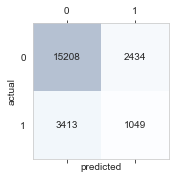

In [22]:
run_model(BernoulliNB(), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: BernoulliNB
Sampling: up-sampled
Mean Training Accuracy: 0.666
Std Training Accuracy: 0.004
Test Accuracy: 0.525
Recall: 0.915
Precision: 0.287
F1 Score: 0.437
Runtime: 1.28629


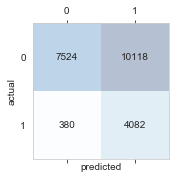

In [23]:
run_model(BernoulliNB(), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")

###### Results ######
Model: BernoulliNB
Sampling: down-sampled
Mean Training Accuracy: 0.667
Std Training Accuracy: 0.008
Test Accuracy: 0.525
Recall: 0.915
Precision: 0.287
F1 Score: 0.437
Runtime: 0.32812


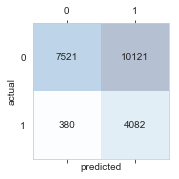

In [24]:
run_model(BernoulliNB(), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")

###### Results ######
Model: BernoulliNB
Sampling: smote
Mean Training Accuracy: 0.667
Std Training Accuracy: 0.004
Test Accuracy: 0.523
Recall: 0.919
Precision: 0.287
F1 Score: 0.438
Runtime: 1.26236


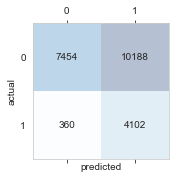

In [25]:
run_model(BernoulliNB(), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

### K Nearest Neighbors

###### Results ######
Model: KNeighborsClassifier
Sampling: none
Mean Training Accuracy: 0.764
Std Training Accuracy: 0.004
Test Accuracy: 0.771
Recall: 0.176
Precision: 0.363
F1 Score: 0.237
Runtime: 58.42718


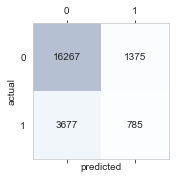

In [26]:
run_model(KNeighborsClassifier(), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: KNeighborsClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.690
Std Training Accuracy: 0.005
Test Accuracy: 0.668
Recall: 0.562
Precision: 0.318
F1 Score: 0.406
Runtime: 103.57118


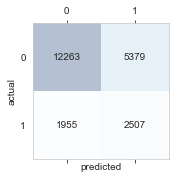

In [27]:
run_model(KNeighborsClassifier(), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")

###### Results ######
Model: KNeighborsClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.565
Std Training Accuracy: 0.012
Test Accuracy: 0.473
Recall: 0.718
Precision: 0.236
F1 Score: 0.355
Runtime: 9.63139


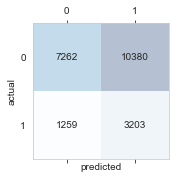

In [28]:
run_model(KNeighborsClassifier(), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")

###### Results ######
Model: KNeighborsClassifier
Sampling: smote
Mean Training Accuracy: 0.698
Std Training Accuracy: 0.014
Test Accuracy: 0.700
Recall: 0.441
Precision: 0.322
F1 Score: 0.372
Runtime: 99.97495


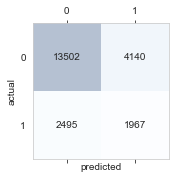

In [29]:
run_model(KNeighborsClassifier(), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

### Decision Tree

###### Results ######
Model: DecisionTreeClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.001
Precision: 0.750
F1 Score: 0.001
Runtime: 1.32345


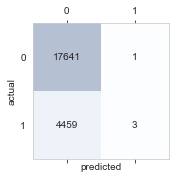

In [30]:
run_model(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: DecisionTreeClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.672
Std Training Accuracy: 0.003
Test Accuracy: 0.558
Recall: 0.867
Precision: 0.296
F1 Score: 0.442
Runtime: 2.46439


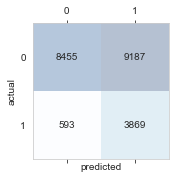

In [31]:
run_model(DecisionTreeClassifier(max_depth=5), X_train_up, y_train_up, X_test, y_test, results, sample_method="up-sampled")

###### Results ######
Model: DecisionTreeClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.672
Std Training Accuracy: 0.010
Test Accuracy: 0.567
Recall: 0.856
Precision: 0.300
F1 Score: 0.444
Runtime: 0.46934


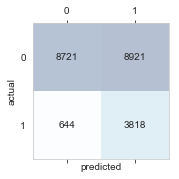

In [32]:
run_model(DecisionTreeClassifier(max_depth=5), X_train_down, y_train_down, X_test, y_test, results, sample_method="down-sampled")

###### Results ######
Model: DecisionTreeClassifier
Sampling: smote
Mean Training Accuracy: 0.683
Std Training Accuracy: 0.014
Test Accuracy: 0.601
Recall: 0.756
Precision: 0.304
F1 Score: 0.434
Runtime: 2.60700


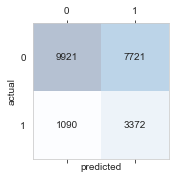

In [33]:
run_model(DecisionTreeClassifier(max_depth=5), X_train_smote, y_train_smote, X_test, y_test, results, sample_method="smote")

### Random Forest

###### Results ######
Model: RandomForestClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.000
Precision: 0.000
F1 Score: 0.000
Runtime: 13.95055


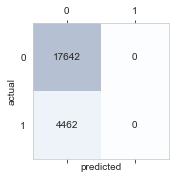

In [34]:
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: RandomForestClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.004
Test Accuracy: 0.522
Recall: 0.923
Precision: 0.287
F1 Score: 0.438
Runtime: 23.83194


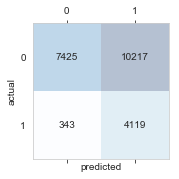

In [35]:
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")

###### Results ######
Model: RandomForestClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.009
Test Accuracy: 0.525
Recall: 0.917
Precision: 0.288
F1 Score: 0.438
Runtime: 4.69047


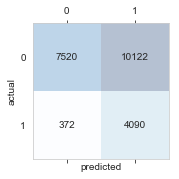

In [36]:
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")

###### Results ######
Model: RandomForestClassifier
Sampling: smote
Mean Training Accuracy: 0.689
Std Training Accuracy: 0.014
Test Accuracy: 0.579
Recall: 0.816
Precision: 0.300
F1 Score: 0.439
Runtime: 27.52300


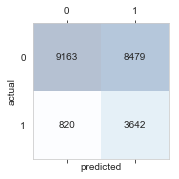

In [37]:
run_model(RandomForestClassifier(n_estimators=50, max_depth=5), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Logisitic Regression

###### Results ######
Model: LogisticRegression
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.002
Precision: 0.368
F1 Score: 0.003
Runtime: 2.92317


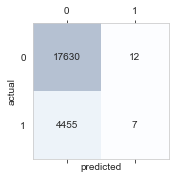

In [38]:
run_model(LogisticRegression(C=1000), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: LogisticRegression
Sampling: up-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.002
Test Accuracy: 0.554
Recall: 0.873
Precision: 0.295
F1 Score: 0.441
Runtime: 4.39227


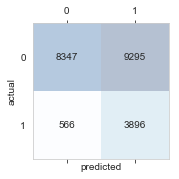

In [39]:
run_model(LogisticRegression(C=1000), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")

###### Results ######
Model: LogisticRegression
Sampling: down-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.008
Test Accuracy: 0.551
Recall: 0.877
Precision: 0.294
F1 Score: 0.441
Runtime: 1.08310


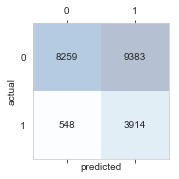

In [40]:
run_model(LogisticRegression(C=1000), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")

###### Results ######
Model: LogisticRegression
Sampling: smote
Mean Training Accuracy: 0.671
Std Training Accuracy: 0.005
Test Accuracy: 0.563
Recall: 0.850
Precision: 0.297
F1 Score: 0.440
Runtime: 5.31078


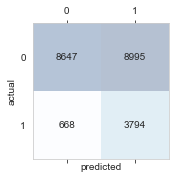

In [41]:
run_model(LogisticRegression(C=1000), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Ridge Classification

###### Results ######
Model: RidgeClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.001
Precision: 0.250
F1 Score: 0.001
Runtime: 0.67220


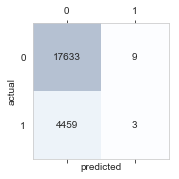

In [42]:
run_model(RidgeClassifier(), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: RidgeClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.003
Test Accuracy: 0.548
Recall: 0.888
Precision: 0.294
F1 Score: 0.442
Runtime: 0.98935


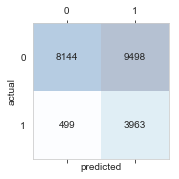

In [43]:
run_model(RidgeClassifier(), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")

###### Results ######
Model: RidgeClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.008
Test Accuracy: 0.544
Recall: 0.894
Precision: 0.293
F1 Score: 0.442
Runtime: 0.27726


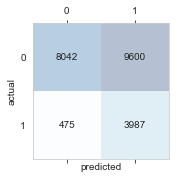

In [44]:
run_model(RidgeClassifier(), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")

###### Results ######
Model: RidgeClassifier
Sampling: smote
Mean Training Accuracy: 0.670
Std Training Accuracy: 0.005
Test Accuracy: 0.557
Recall: 0.864
Precision: 0.295
F1 Score: 0.440
Runtime: 0.92851


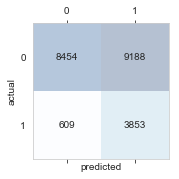

In [45]:
run_model(RidgeClassifier(), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Lasso Regression

###### Results ######
Model: LogisticRegression
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.002
Precision: 0.368
F1 Score: 0.003
Runtime: 2.70974


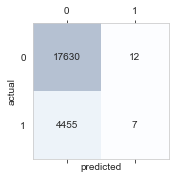

In [46]:
run_model(LogisticRegression(penalty="l1"), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: LogisticRegression
Sampling: up-sampled
Mean Training Accuracy: 0.669
Std Training Accuracy: 0.002
Test Accuracy: 0.554
Recall: 0.874
Precision: 0.295
F1 Score: 0.442
Runtime: 4.04520


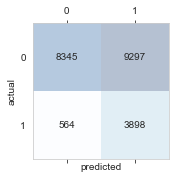

In [47]:
run_model(LogisticRegression(penalty="l1"), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")

###### Results ######
Model: LogisticRegression
Sampling: down-sampled
Mean Training Accuracy: 0.668
Std Training Accuracy: 0.008
Test Accuracy: 0.551
Recall: 0.878
Precision: 0.294
F1 Score: 0.441
Runtime: 0.94151


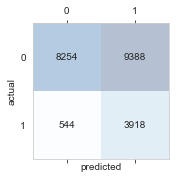

In [48]:
run_model(LogisticRegression(penalty="l1"), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")

###### Results ######
Model: LogisticRegression
Sampling: smote
Mean Training Accuracy: 0.671
Std Training Accuracy: 0.005
Test Accuracy: 0.563
Recall: 0.850
Precision: 0.297
F1 Score: 0.440
Runtime: 4.20178


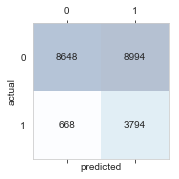

In [49]:
run_model(LogisticRegression(penalty="l1"), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Support Vector Machines

###### Results ######
Model: SVC
Sampling: none
Mean Training Accuracy: 0.778
Std Training Accuracy: 0.017
Test Accuracy: 0.791
Recall: 0.032
Precision: 0.330
F1 Score: 0.058
Runtime: 5.50827


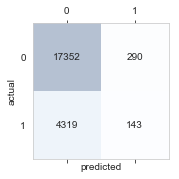

In [50]:
run_model(SVC(max_iter=50), X_train, y_train, X_test, y_test, results)

###### Results ######
Model: SVC
Sampling: up-sampled
Mean Training Accuracy: 0.528
Std Training Accuracy: 0.002
Test Accuracy: 0.772
Recall: 0.128
Precision: 0.331
F1 Score: 0.184
Runtime: 7.77318


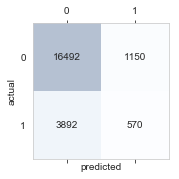

In [51]:
run_model(SVC(max_iter=50), X_train_up, y_train_up, X_test, y_test,
          results, sample_method="up-sampled")

###### Results ######
Model: SVC
Sampling: down-sampled
Mean Training Accuracy: 0.378
Std Training Accuracy: 0.006
Test Accuracy: 0.476
Recall: 0.304
Precision: 0.138
F1 Score: 0.190
Runtime: 2.04455


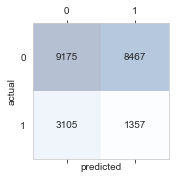

In [52]:
run_model(SVC(max_iter=50), X_train_down, y_train_down, X_test, y_test,
          results, sample_method="down-sampled")

###### Results ######
Model: SVC
Sampling: smote
Mean Training Accuracy: 0.521
Std Training Accuracy: 0.006
Test Accuracy: 0.776
Recall: 0.110
Precision: 0.332
F1 Score: 0.165
Runtime: 8.43740


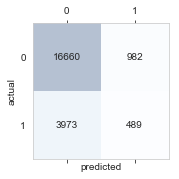

In [53]:
run_model(SVC(max_iter=50), X_train_smote, y_train_smote, X_test, y_test,
          results, sample_method="smote")

### Gradient Boosting

###### Results ######
Model: GradientBoostingClassifier
Sampling: none
Mean Training Accuracy: 0.798
Std Training Accuracy: 0.000
Test Accuracy: 0.798
Recall: 0.007
Precision: 0.542
F1 Score: 0.014
Runtime: 262.85480


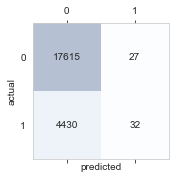

In [54]:
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train, y_train, X_test, y_test,
          results)

###### Results ######
Model: GradientBoostingClassifier
Sampling: up-sampled
Mean Training Accuracy: 0.672
Std Training Accuracy: 0.003
Test Accuracy: 0.564
Recall: 0.863
Precision: 0.299
F1 Score: 0.444
Runtime: 458.81428


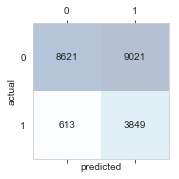

In [55]:
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_up, y_train_up,
          X_test, y_test, results, sample_method="up-sampled")

###### Results ######
Model: GradientBoostingClassifier
Sampling: down-sampled
Mean Training Accuracy: 0.671
Std Training Accuracy: 0.010
Test Accuracy: 0.566
Recall: 0.855
Precision: 0.299
F1 Score: 0.443
Runtime: 88.20113


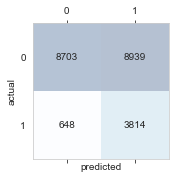

In [56]:
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_down, y_train_down,
          X_test, y_test, results, sample_method="down-sampled")

###### Results ######
Model: GradientBoostingClassifier
Sampling: smote
Mean Training Accuracy: 0.726
Std Training Accuracy: 0.055
Test Accuracy: 0.658
Recall: 0.597
Precision: 0.316
F1 Score: 0.413
Runtime: 499.54416


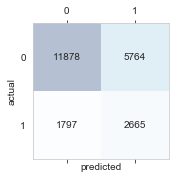

In [57]:
run_model(GradientBoostingClassifier(n_estimators=500, max_depth=2, loss="deviance"), X_train_smote, y_train_smote,
          X_test, y_test, results, sample_method="smote")

In [58]:
results_df = pd.DataFrame(results)
results_df

,model,sample_method,mean_train_acc,std_train_acc,test_acc,tp,tn,fp,fn,recall,precision,f1_score,runtime
0,BernoulliNB,none,0.739255,0.008702,0.735478,1049,15208,2434,3413,0.235096,0.301177,0.264065,0.889265
1,BernoulliNB,up-sampled,0.666263,0.003540,0.525063,4082,7524,10118,380,0.914836,0.287465,0.437467,1.286285
2,BernoulliNB,down-sampled,0.666675,0.007866,0.524928,4082,7521,10121,380,0.914836,0.287404,0.437396,0.328120
3,BernoulliNB,smote,0.666653,0.003704,0.522801,4102,7454,10188,360,0.919319,0.287054,0.437500,1.262364
4,KNeighborsClassifier,none,0.764376,0.003544,0.771444,785,16267,1375,3677,0.175930,0.363426,0.237088,58.427181
5,KNeighborsClassifier,up-sampled,0.689795,0.005271,0.668205,2507,12263,5379,1955,0.561856,0.317905,0.406058,103.571180
6,KNeighborsClassifier,down-sampled,0.564933,0.011868,0.473444,3203,7262,10380,1259,0.717840,0.235809,0.355001,9.631387
7,KNeighborsClassifier,smote,0.697937,0.013978,0.699828,1967,13502,4140,2495,0.440834,0.322089,0.372221,99.974952
8,DecisionTreeClassifier,none,0.798184,0.000102,0.798227,3,17641,1,4459,0.000672,0.750000,0.001343,1.323452
9,DecisionTreeClassifier,up-sampled,0.671768,0.002637,0.557546,3869,8455,9187,593,0.867100,0.296339,0.441717,2.464386


In [59]:
results_df[(results_df["sample_method"] != "none")].sort_values("precision", ascending=False)

,model,sample_method,mean_train_acc,std_train_acc,test_acc,tp,tn,fp,fn,recall,precision,f1_score,runtime
31,SVC,smote,0.520826,0.006350,0.775832,489,16660,982,3973,0.109592,0.332427,0.164841,8.437400
29,SVC,up-sampled,0.528457,0.002404,0.771896,570,16492,1150,3892,0.127745,0.331395,0.184406,7.773180
7,KNeighborsClassifier,smote,0.697937,0.013978,0.699828,1967,13502,4140,2495,0.440834,0.322089,0.372221,99.974952
5,KNeighborsClassifier,up-sampled,0.689795,0.005271,0.668205,2507,12263,5379,1955,0.561856,0.317905,0.406058,103.571180
35,GradientBoostingClassifier,smote,0.725936,0.055085,0.657935,2665,11878,5764,1797,0.597266,0.316170,0.413467,499.544160
11,DecisionTreeClassifier,smote,0.683418,0.014058,0.601384,3372,9921,7721,1090,0.755715,0.303975,0.433558,2.607001
15,RandomForestClassifier,smote,0.689250,0.013523,0.579307,3642,9163,8479,820,0.816226,0.300470,0.439245,27.522998
10,DecisionTreeClassifier,down-sampled,0.671886,0.010154,0.567273,3818,8721,8921,644,0.855670,0.299710,0.443928,0.469338
33,GradientBoostingClassifier,up-sampled,0.672130,0.003301,0.564151,3849,8621,9021,613,0.862618,0.299068,0.444150,458.814276
34,GradientBoostingClassifier,down-sampled,0.670877,0.010199,0.566278,3814,8703,8939,648,0.854774,0.299067,0.443102,88.201129


### Tune SVC\SMOTE

In [98]:
# Set up results dictionary
results_tuned = {"model": [], "sample_method":[], "mean_train_acc": [], "std_train_acc": [],
           "test_acc": [], "tp": [], "tn": [], "fp": [], "fn": [], "recall": [],
           "precision": [], "f1_score": [], "runtime": []}

In [99]:
svc = SVC()
param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000],
             "max_iter": [50, 100, 250, 500]}

gs_svc = GridSearchCV(estimator=svc,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_svc.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'max_iter': [50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [100]:
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.5343026798747219
{'C': 10000, 'max_iter': 500}


###### Results ######
Model: SVC
Sampling: smote
Mean Training Accuracy: 0.506
Std Training Accuracy: 0.084
Test Accuracy: 0.778
Recall: 0.100
Precision: 0.334
F1 Score: 0.153
Runtime: 62.69752


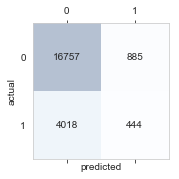

In [101]:
run_model(SVC(C=10000, max_iter=500), X_train_smote, y_train_smote, X_test, y_test,
          results_tuned, sample_method="smote")

### Tune KNeighbors\SMOTE

In [104]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 30, 1),
             "weights": ["uniform", "distance"]}

gs_knn = GridSearchCV(estimator=knn,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_knn.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [105]:
print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.7237220639712031
{'n_neighbors': 29, 'weights': 'distance'}


###### Results ######
Model: KNeighborsClassifier
Sampling: smote
Mean Training Accuracy: 0.726
Std Training Accuracy: 0.040
Test Accuracy: 0.703
Recall: 0.442
Precision: 0.326
F1 Score: 0.375
Runtime: 131.34829


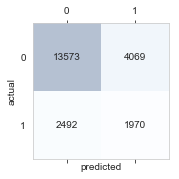

In [108]:
run_model(KNeighborsClassifier(n_neighbors=29, weights="distance"), X_train_smote, y_train_smote,
          X_test, y_test, results_tuned, sample_method="smote")

### Tune GradientBoosting\SMOTE

In [111]:
gbc = GradientBoostingClassifier()
param_grid = {"n_estimators": [50, 100, 250, 500, 1000]}

gs_gbc = GridSearchCV(estimator=gbc,
                    param_grid = param_grid,
                    scoring="accuracy",
                    cv=5,
                    n_jobs=-1)
gs_gbc.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [112]:
print(gs_gbc.best_score_)
print(gs_gbc.best_params_)

0.7317857800830464
{'n_estimators': 1000}


###### Results ######
Model: GradientBoostingClassifier
Sampling: smote
Mean Training Accuracy: 0.736
Std Training Accuracy: 0.067
Test Accuracy: 0.675
Recall: 0.524
Precision: 0.316
F1 Score: 0.394
Runtime: 1471.91745


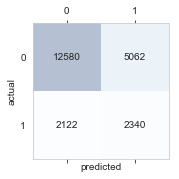

In [113]:
run_model(GradientBoostingClassifier(n_estimators=1000), X_train_smote, y_train_smote,
          X_test, y_test, results_tuned, sample_method="smote")

In [114]:
results_df = pd.DataFrame(results_tuned)
results_df

,model,sample_method,mean_train_acc,std_train_acc,test_acc,tp,tn,fp,fn,recall,precision,f1_score,runtime
0,SVC,smote,0.505669,0.084038,0.778185,444,16757,885,4018,0.099507,0.334086,0.153341,62.697517
1,KNeighborsClassifier,smote,0.726098,0.039745,0.703176,1970,13573,4069,2492,0.441506,0.326213,0.375202,131.348292
2,GradientBoostingClassifier,smote,0.735581,0.067135,0.674991,2340,12580,5062,2122,0.524429,0.316131,0.394471,1471.917450
